In [2]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})


/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()
2025-10-02 14:31:56.838437: W external/xla/xla/service/platform_util.cc:220] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [3]:
exp_data = LorenzExp
initial_state = jnp.array([ -5, 0., 5])
initial_state = jnp.array([ -8,8,27.])
dt = 0.5
noise_var = .05
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

In [37]:
plt.style.use('default')
# plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'

In [38]:
x_train = expdata.x_train
t_train = expdata.t_train

x_true = expdata.x_true
t_true = expdata.t_true


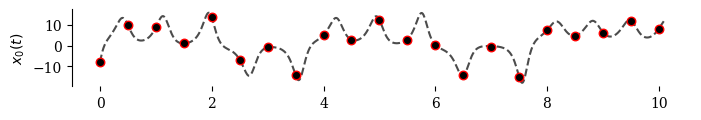

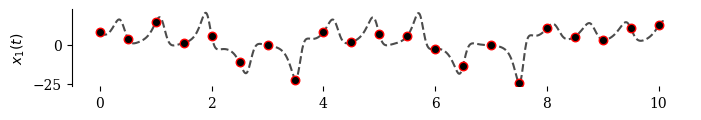

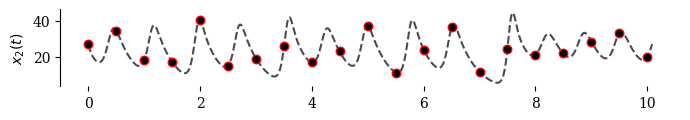

In [39]:
y_labels = [r"$x_0(t)$",r"$x_1(t)$",r"$x_2(t)$"]
for idx in range(len(x_true.T)):
    fig, ax = plt.subplots(1,1,figsize=(8,1))
    # plt.figure(figsize=(8,3))
    ax.plot(t_true, x_true[:,idx], linestyle='--',c='black',alpha=0.7,zorder=1)
    ax.scatter(t_train,x_train[:,idx],zorder=2,facecolors='black',edgecolors='red',marker='.',s=150,lw=1)
    ax.set_ylabel(y_labels[idx])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

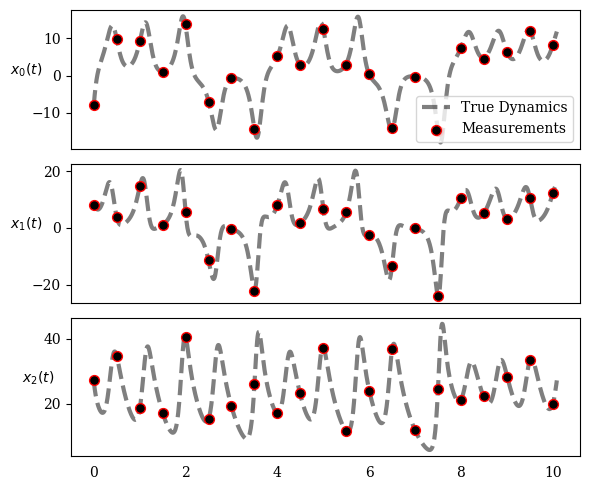

In [40]:
fig, axs = plt.subplots(3,1, figsize=(6,5),sharex=True)

axs = axs.flatten()

for idx, ax in enumerate(axs):
    # ax.grid(True)xX
    ax.plot(t_true, x_true[:,idx], linestyle='--',c='black',alpha=0.5,zorder=1,lw=3,label="True Dynamics")
    ax.scatter(t_train,x_train[:,idx],zorder=2,facecolors='black',edgecolors='red',marker='.',s=200,lw=1,label="Measurements")
    ax.set_ylabel(y_labels[idx],rotation=0)
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    if idx > 2:
        ax.spines['bottom'].set_visible(False)
    ax.tick_params(right=False, top=False,bottom=False) # Removes ticks
    ax.tick_params(labelright=False, labeltop=False) # Removes tick labels
    if idx ==0:
        ax.legend(loc='lower right')

plt.tight_layout()


$$
\mathcal{L}(x,\theta) \triangleq \underbrace{\frac{1}{2} \sum_{n=1}^N\left|V_n^T x(t_i) - y_i\right|^2}_{\text{RKHS}} +\underbrace{\frac{1}{2}\sum_{j=1}^{M} w_j
\left| \frac{d^p}{dt^p}\mathbf{x}(\tau_j) - f\left(x(\tau_j),\dots,\frac{d^{p-1}}{dt^{p-1}}x(\tau_j)\right)\right|^2}_{\text{Dynamics loss}} 
+ \frac{\lambda}{2} \|\mathbf{x}\|^2_{\mathcal{X}} + R(\theta)
$$

$$

$$

$$
\begin{align}
\mathcal{L}(x,\theta) &\triangleq \underbrace{\frac{1}{2} \sum_{n=1}^N\left|V_n^T x(t_i) - y_i\right|^2}_{\text{RKHS}}\\
 &+\underbrace{\frac{1}{2}\sum_{j=1}^{M} w_j
\left| \frac{d^p}{dt^p}\mathbf{x}(\tau_j) - f\left(x(\tau_j),\dots,\frac{d^{p-1}}{dt^{p-1}}x(\tau_j)\right)\right|^2}_{\text{Dynamics loss}} 
+ \frac{\lambda}{2} \|\mathbf{x}\|^2_{\mathcal{X}} + R(\theta)
\end{align}
$$

$$
\text{RKHS Interpolant}
$$